# Module Setup

In [1]:
_BATCH = 32
_EPOCHS = 40
_CLASSES = 10
# Image augmentation may be neccesary for jitter and more examples
_AUGMENT = True
from keras.datasets import cifar10
from keras import callbacks as kCall
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras.engine.topology import InputLayer
from keras.utils import np_utils, generic_utils
from keras import backend as K
from keras.constraints import MaxNorm
K.set_image_dim_ordering('th')
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pdb
from keras import layers
import math
from tqdm import tqdm
import os

Using TensorFlow backend.


# Importing the dataset

In [2]:
(trainX,trainY),(testX,testY) = cifar10.load_data()
print ('train Shape:  ', trainX.shape)
print ('train Exmpl:  ', trainX.shape[0])
print ('test  Exmpl:  ', testX.shape[0])
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255.0
testX /= 255.0

trainY  = np_utils.to_categorical(trainY)
testY   = np_utils.to_categorical(testY)
_CLASSES = trainY.shape[1]

train Shape:   (50000, 3, 32, 32)
train Exmpl:   50000
test  Exmpl:   10000


# Loading a model

Here we load one of the saved models for visualization

In [3]:
wtN = 39
wtN = str(wtN).zfill(2)
file="weights/wt-" + wtN + ".hdf5"
model = keras.models.Sequential()
model = keras.models.load_model("model_params")
model.load_weights(file)

Just a quick evaluation to ensure that the model was loaded correctly. We run on a subset of the test images for faster computation on a CPU. subset can be expanded for faster machines.

In [4]:
nums=500
scores=model.evaluate(testX[0:nums,:,:,:],testY[0:nums,:])

500/500 [==============================] - ETA: 3s - ETA: 2s - ETA: 2s - ETA: 2s - ETA: 1s - ETA: 1s - ETA: 1s - ETA: 1s - ETA: 1s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - 2s     


In [5]:
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 17.80%


## Layers
The layer notations of our model are given.

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
__________

In [8]:
layerCount=-1
for layer in model.layers:
    layerCount+=1
    if layer.__class__.__name__ == "Conv2D":
        print (str(layerCount).rjust(2) + "  " + 
               layer.name.ljust(15) + "  :  " + 
               layer.get_config()['name'].ljust(15) + "  " + 
               str(layer.get_config()['filters']) + "  " + 
               str(layer.get_config()['kernel_size']))
    elif layer.__class__.__name__ == "Flatten":
        fLayer = layerCount  
        print (str(layerCount).rjust(2) + "  " + layer.__class__.__name__.ljust(15) + "  :  " + layer.get_config()['name'])
    else:
        print (str(layerCount).rjust(2) + "  " + layer.__class__.__name__.ljust(15) + "  :  " + layer.get_config()['name'])

 0  conv2d_1         :  conv2d_1         32  (3, 3)
 1  Dropout          :  dropout_1
 2  conv2d_2         :  conv2d_2         32  (3, 3)
 3  MaxPooling2D     :  max_pooling2d_1
 4  conv2d_3         :  conv2d_3         64  (3, 3)
 5  Dropout          :  dropout_2
 6  conv2d_4         :  conv2d_4         64  (3, 3)
 7  MaxPooling2D     :  max_pooling2d_2
 8  conv2d_5         :  conv2d_5         128  (3, 3)
 9  Dropout          :  dropout_3
10  conv2d_6         :  conv2d_6         128  (3, 3)
11  MaxPooling2D     :  max_pooling2d_3
12  Flatten          :  flatten_1
13  Dropout          :  dropout_4
14  Dense            :  dense_1
15  Dropout          :  dropout_5
16  Dense            :  dense_2
17  Dropout          :  dropout_6
18  Dense            :  dense_3


# Visualization
Given a particular output layer (a convolutional layer), we build a new model using the weights for the layers up to that point, and use it to visualize the model output at that layer.

In [7]:
layerOutput = 6
vis_model = Sequential()
cLayer=0
for layer in model.layers:
    nLayer = layers.deserialize({'class_name': layer.__class__.__name__,
                            'config': layer.get_config()})
    
    vis_model.add(nLayer)
    nLayer.set_weights(layer.get_weights())
    #vis_model.layers[cLayer].set_weights(model.layers)
    cLayer+=1
    if cLayer>layerOutput:
        break
print (vis_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
Total para

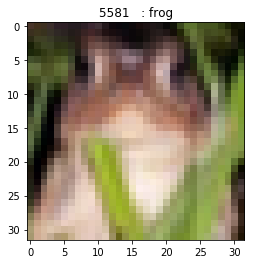

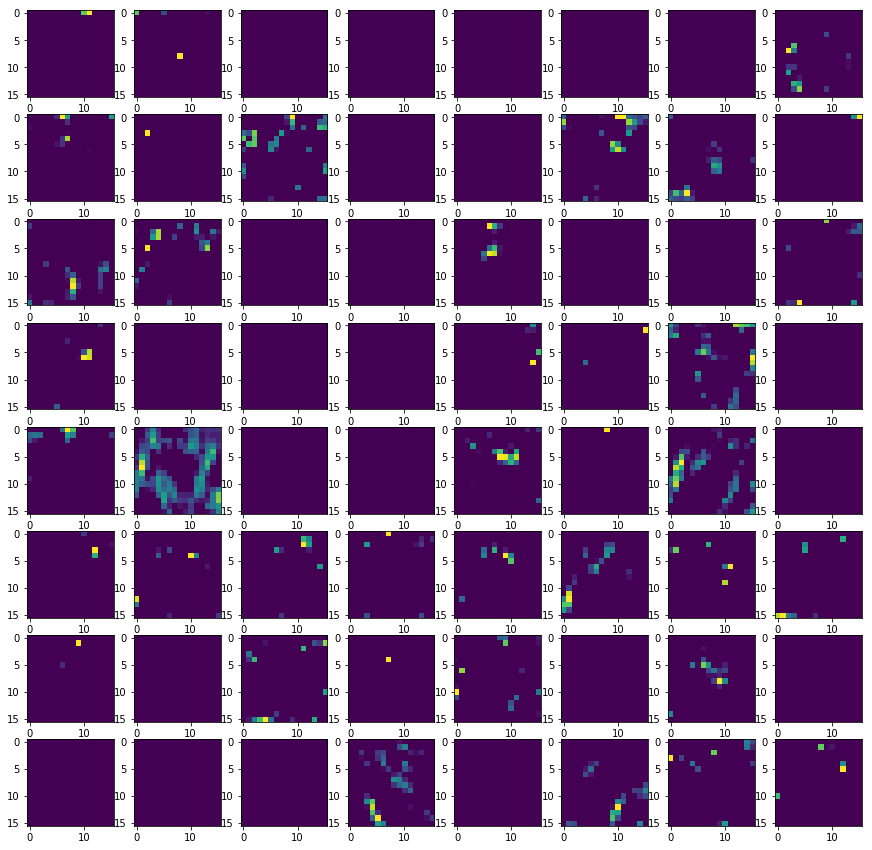

In [8]:
index=random.randrange(9999)
#index=random.sample(range(10000),10)
#index=3125
name_lst = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.imshow(testX[index,:,:,:].transpose(1,2,0))
plt.title(str(index).ljust(6) + " : " + name_lst[int(np.dot(np.linspace(0,9,10),testY[index]))])
plt.show()

vis_layer = vis_model.predict(testX[index:index+1,:,:,:])
# Select the image (i.e. down-dim from 1 -> 0); then transpose to correct imshow format
#vis_layer initial format: [batch index, filter index, imageDim1, imageDim2] -> [imageDim1, imageDim2, filter index]
vis_layer = vis_layer[0,:,:,:]
vis_layer = vis_layer.transpose(1,2,0)
num_plots = vis_layer.shape[2]
side = math.ceil(math.sqrt(num_plots))
fig = plt.figure(figsize=(15,15))
#fig = plt.figure()
for i in range(num_plots):
    a = fig.add_subplot(side,side,i+1)
    plt.imshow(vis_layer[:,:,i])
plt.show()

# Input Image Gradient Ascent
Here we find what features each layer is likely looking for

In [33]:
layerOutput = 11
vis_model = Sequential()
vis_model.add(InputLayer(input_shape=(3,None,None)))
cLayer=0
for layer in model.layers:
    nLayer = layers.deserialize({'class_name': layer.__class__.__name__,
                            'config': layer.get_config()})
    
    vis_model.add(nLayer)
    nLayer.set_weights(layer.get_weights())
    #vis_model.layers[cLayer].set_weights(model.layers)
    cLayer+=1
    if cLayer>layerOutput:
        break
#for layer in vis_model.layers:
#    if type(layer) is keras.layers.core.Dropout:
#        vis_model.layers.remove(layer)
print (vis_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, None, None)    896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, None, None)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, None, None)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, None, None)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, None, None)    18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, None, None)    0         
__________

In [53]:
layerCount=-1
convL = []
for layer in vis_model.layers:
    layerCount+=1
    if layer.__class__.__name__ == "Conv2D":
        print (str(layerCount).rjust(2) + "  " + 
               layer.name.ljust(15) + "  :  " + 
               layer.get_config()['name'].ljust(15) + "  " + 
               str(layer.get_config()['filters']) + "  " + 
               str(layer.get_config()['kernel_size']))
        convL.append(layerCount)
    else:
        print (str(layerCount).rjust(2) + "  " + layer.name.ljust(15) + "  :  " + layer.get_config()['name'])

 0  input_2          :  input_2
 1  conv2d_1         :  conv2d_1         32  (3, 3)
 2  dropout_1        :  dropout_1
 3  conv2d_2         :  conv2d_2         32  (3, 3)
 4  max_pooling2d_1  :  max_pooling2d_1
 5  conv2d_3         :  conv2d_3         64  (3, 3)
 6  dropout_2        :  dropout_2
 7  conv2d_4         :  conv2d_4         64  (3, 3)
 8  max_pooling2d_2  :  max_pooling2d_2
 9  conv2d_5         :  conv2d_5         128  (3, 3)
10  dropout_3        :  dropout_3
11  conv2d_6         :  conv2d_6         128  (3, 3)
12  max_pooling2d_3  :  max_pooling2d_3


In [69]:
def tensor_to_image(tensor):
    print(type(tensor))
    tensor = 0.1*((tensor - tensor.mean())/(tensor.std() + 1e-6))
    tensor = np.clip(tensor+0.5,0,1)
    tensor *= 255
    return np.clip(tensor.transpose(1,2,0),0,255).astype('uint8')

In [51]:
layerSelect = 5
baseDim = 128
in_image = vis_model.input
nu = 1
iterations = 30
#baseForm = np.random.random((1, 3,baseDim,baseDim))
#baseForm = baseForm[0:0,:,:,:]
baseForm = []
assert(vis_model.layers[layerSelect].rank == 2)
layer_dict = dict([(layer.name, layer) for layer in vis_model.layers])
layer_name = vis_model.layers[layerSelect].name
nFilters = vis_model.layers[layerSelect].get_config()['filters']
    
for filterSelect in tqdm(range(nFilters)): 
    baseImage = np.random.random((1, 3,baseDim,baseDim))
    baseImage = 20*(baseImage-0.2) + 128
    layerOut = layer_dict[layer_name].output
    loss = K.mean(layerOut[:,filterSelect,:,:])
    gradients = K.gradients(loss,in_image)[0]
    gradients /= K.sqrt(K.mean(K.square(gradients))) + 1e-6
    lossGrad = K.function([in_image, K.learning_phase()], [loss, gradients])

    for i in range(iterations):
        lossN, gradN = lossGrad([baseImage,1])
        #pdb.set_trace()
        baseImage += gradN*nu
    baseForm.append(np.copy(baseImage))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [08:33<00:00,  7.94s/it]


In [9]:
'''
fig = plt.figure(figsize=(150,150))
side=math.ceil(math.sqrt(nFilters))
if not os.path.exists("layers"):
    os.makedirs("layers")
for i in range(nFilters):
    #a = fig.add_subplot(side,side,i+1)
    plt.imshow(tensor_to_image(baseForm[i][0]))
    plt.savefig("layers/testIm" + str(i)+".png",bbox_inches='tight')
plt.savefig("testIm.png",bbox_inches='tight')
'''

'\nfig = plt.figure(figsize=(150,150))\nside=math.ceil(math.sqrt(nFilters))\nif not os.path.exists("layers"):\n    os.makedirs("layers")\nfor i in range(nFilters):\n    #a = fig.add_subplot(side,side,i+1)\n    plt.imshow(tensor_to_image(baseForm[i][0]))\n    plt.savefig("layers/testIm" + str(i)+".png",bbox_inches=\'tight\')\nplt.savefig("testIm.png",bbox_inches=\'tight\')\n'

# Training Maximizer

In [228]:
layerOutput = fLayer-1
vis_model = Sequential()
vis_model.add(InputLayer(input_shape=(3,None,None)))
cLayer=0
for layer in model.layers:
    nLayer = layers.deserialize({'class_name': layer.__class__.__name__,
                            'config': layer.get_config()})
    vis_model.add(nLayer)
    nLayer.set_weights(layer.get_weights())
    cLayer+=1
    if cLayer>layerOutput:
        break
print (vis_model.summary())

layerCount=-1
convL = []
for layer in vis_model.layers:
    layerCount+=1
    if layer.__class__.__name__ == "Conv2D":
        print (str(layerCount).rjust(2) + "  " + 
               layer.name.ljust(15) + "  :  " + 
               layer.get_config()['name'].ljust(15) + "  " + 
               str(layer.get_config()['filters']) + "  " + 
               str(layer.get_config()['kernel_size']))
        convL.append(layerCount)
    else:
        print (str(layerCount).rjust(2) + "  " + layer.name.ljust(15) + "  :  " + layer.get_config()['name'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, None, None)    896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, None, None)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, None, None)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, None, None)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, None, None)    18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, None, None)    0         
__________

In [39]:
vis_outputs = vis_model.layers[1].output
#[layer.output for layer in vis_model.layers]
vis_eval = K.function([vis_input, K.learning_phase()], [vis_outputs])

In [46]:
res=vis_eval([trainX[0:1],1.])
layerSelect=convL[0]
layer_dict = dict([(layer.name, layer) for layer in vis_model.layers])
layer_name = vis_model.layers[layerSelect].name
nFilters = vis_model.layers[layerSelect].get_config()['filters']

In [229]:
max_activations = [np.zeros(vis_model.layers[convLayer].get_config()['filters']) for convLayer in convL]
max_image_index = [np.zeros(vis_model.layers[convLayer].get_config()['filters']) for convLayer in convL]

for img in tqdm(range(60000)):
    vis_input = vis_model.input
    loss = [K.mean(layer.output,axis=[2,3]) for layer in [vis_model.layers[i] for i in convL]]
    #loss = [K.mean(layer.output,axis=[2,3]) for layer in vis_model.layers]
    lossGrad = K.function([vis_input, K.learning_phase()], loss)
    lossT = lossGrad([trainX[img:img+1],0])

    residues=[max_activations[i]-lossT[i] for i in range(len(convL))]
    for i in range(len(convL)):
        max_image_index[i][np.where(residues[i]<0)[1]] = img
        max_activations[i][np.where(residues[i]<0)[1]]=lossT[i][0,np.where(residues[i]<0)[1]]

  3%|█▋                                                    | 1825/60000 [11:05<10:49:51,  1.49it/s]

KeyboardInterrupt: 

In [227]:
max_image_index[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
        1.,  5.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  5.])

In [231]:
trainX[0,:,:,:].shape

(3, 32, 32)

In [176]:
residues=[max_activations[i]-lossT[i] for i in range(len(convL))]
for i in range(len(convL)):
    max_image_index[i][np.where(residues[i]<0)[1]] = img
    max_activations[i][np.where(residues[i]<0)[1]]=lossT[i][0,np.where(residues[i]<0)[1]]